In [3]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../../NLPofTimFerrissShow'))
	print(os.getcwd())
except:
	pass


/Users/robert/Documents/NLPofTimFerrissShow


In [9]:
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim

# Load models
from sklearn import ensemble, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Import raw data
# This data set contains the transcripts of Tim Ferriss Podcasts
# Source: https://tim.blog/2018/09/20/all-transcripts-from-the-tim-ferriss-show/
questions = pd.read_csv("./raw/transcripts_raw.csv")
questions.columns=['title', 'text']
questions.head()

title  \
0    The Tim Ferriss Show Transcripts: Caroline Paul   
1  The Tim Ferriss Show Transcripts: On Philosoph...   
2        The Tim Ferriss Show Transcripts: BJ Miller   
3     The Tim Ferriss Show Transcripts: Paulo Coelho   
4  The Tim Ferriss Show Transcripts: On Zero-to-H...   

                                                text  
0  '\xa0''Tim Ferriss: Hello, druids and drow elv...  
1  '\xa0''Hello, ladies and germs. This is Tim Fe...  
2  '\xa0''Tim Ferriss: Hello, ladies and germs. T...  
3  '\xa0''Tim Ferriss: Hello, boys and girls, lad...  
4  '\xa0''\xa0''Tim Ferriss:\xa0Good golly, Miss ...

In [6]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"\\xa0", "")
    df[text_field] = df[text_field].str.replace(r"xa0", "")
    df[text_field] = df[text_field].str.replace(r" ''Tim Ferriss", "")
    df[text_field] = df[text_field].str.replace(r" n n''Tim Ferriss", "")
    df[text_field] = df[text_field].str.replace(r" n''Tim Ferriss", "")
    df[text_field] = df[text_field].str.lower()
    return df

questions['title'] = questions['title'].str.replace(r"The Tim Ferriss Show Transcripts: ", "")
questions['title'] = questions['title'].str.replace(r"Transcripts: ", "")
questions = standardize_text(questions, "text")

questions.to_csv("./cleaned/transcripts_cleaned.csv")


In [7]:
clean_questions = pd.read_csv("./cleaned/transcripts_cleaned.csv")
clean_questions.head()


Unnamed: 0                            title  \
0           0                    Caroline Paul   
1           1         On Philosophy and Riches   
2           2                        BJ Miller   
3           3                     Paulo Coelho   
4           4  On Zero-to-Hero Transformations   

                                                text  
0  '  hello, druids and drow elves  this is tim f...  
1  ' ''hello, ladies and germs  this is tim ferri...  
2  '  hello, ladies and germs  this is tim ferris...  
3  '  hello, boys and girls, ladies and germs  th...  
4  ' ''  good golly, miss molly  this is tim ferr...

In [10]:
tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

#  StopWords
stop_words = set(stopwords.words('english'))
clean_questions["tokens"] = clean_questions["tokens"].map(lambda x: [w for w in x if not w in stop_words])

# Lemmatize
# TODO

# Inspecting our dataset a little more

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max episode length is %s" % max(sentence_lengths))
print("Mean episode length is %s" % np.mean(sentence_lengths))

def plot_TSNE(test_data, test_labels, plot=True):
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, early_exaggeration=20)
        tsne_results = tsne.fit_transform(test_data) #for TFIDF -> test_data.toarray()
        #print(tsne_results)
        if plot:
            x = tsne_results[:,0]
            y = tsne_results[:,1]
            plt.scatter(x, y, s=10, alpha=1)
            for i,label in enumerate(test_labels):
                plt.text(x[i], y[i], label, fontsize=14)

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        if plot:
            x = lsa_scores[:,0]
            y = lsa_scores[:,1]
            plt.scatter(x, y, s=10, alpha=1)
            for i,label in enumerate(test_labels):
                plt.text(x[i], y[i], label, fontsize=14)


1342668 words total, with a vocabulary size of 38089
Max episode length is 15679
Mean episode length is 6455.134615384615


 # Bag of Words Counts

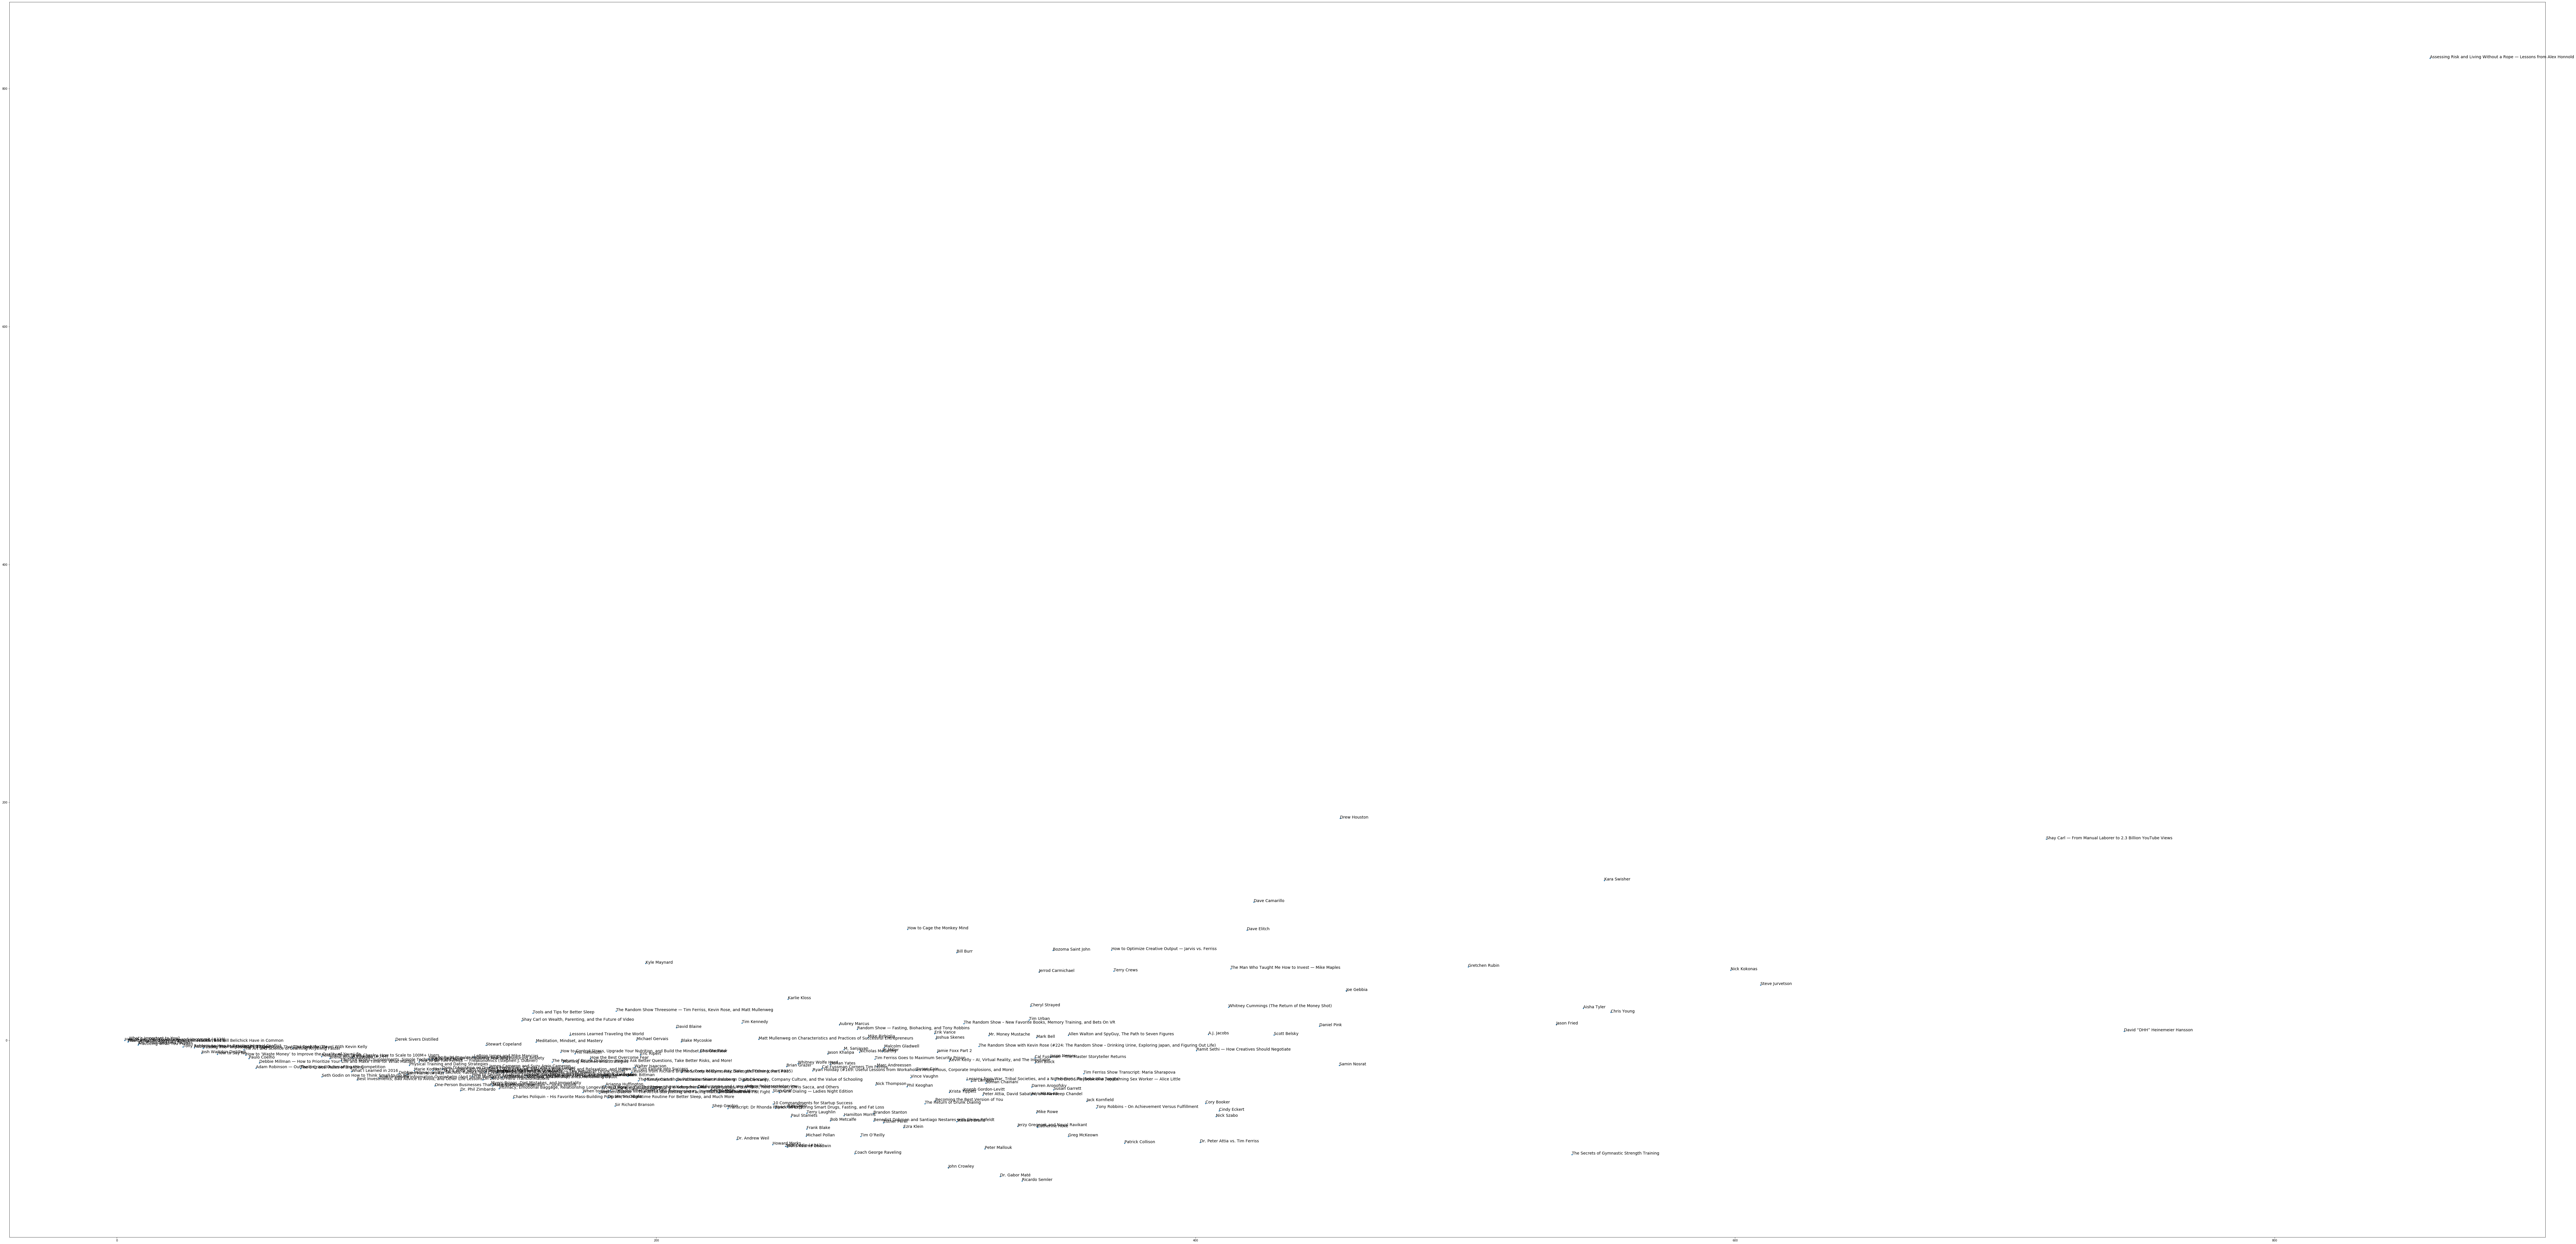

In [11]:
def cv(data):
    count_vectorizer = CountVectorizer(stop_words='english')

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

X_train = clean_questions["text"].tolist()
y_train = clean_questions["title"].tolist()       

X_train_counts, count_vectorizer = cv(X_train)

# Plot Embeddings

fig = plt.figure(figsize=(160, 80))
plot_LSA(X_train_counts, y_train)
plt.show()


 ## TF DF

In [12]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)



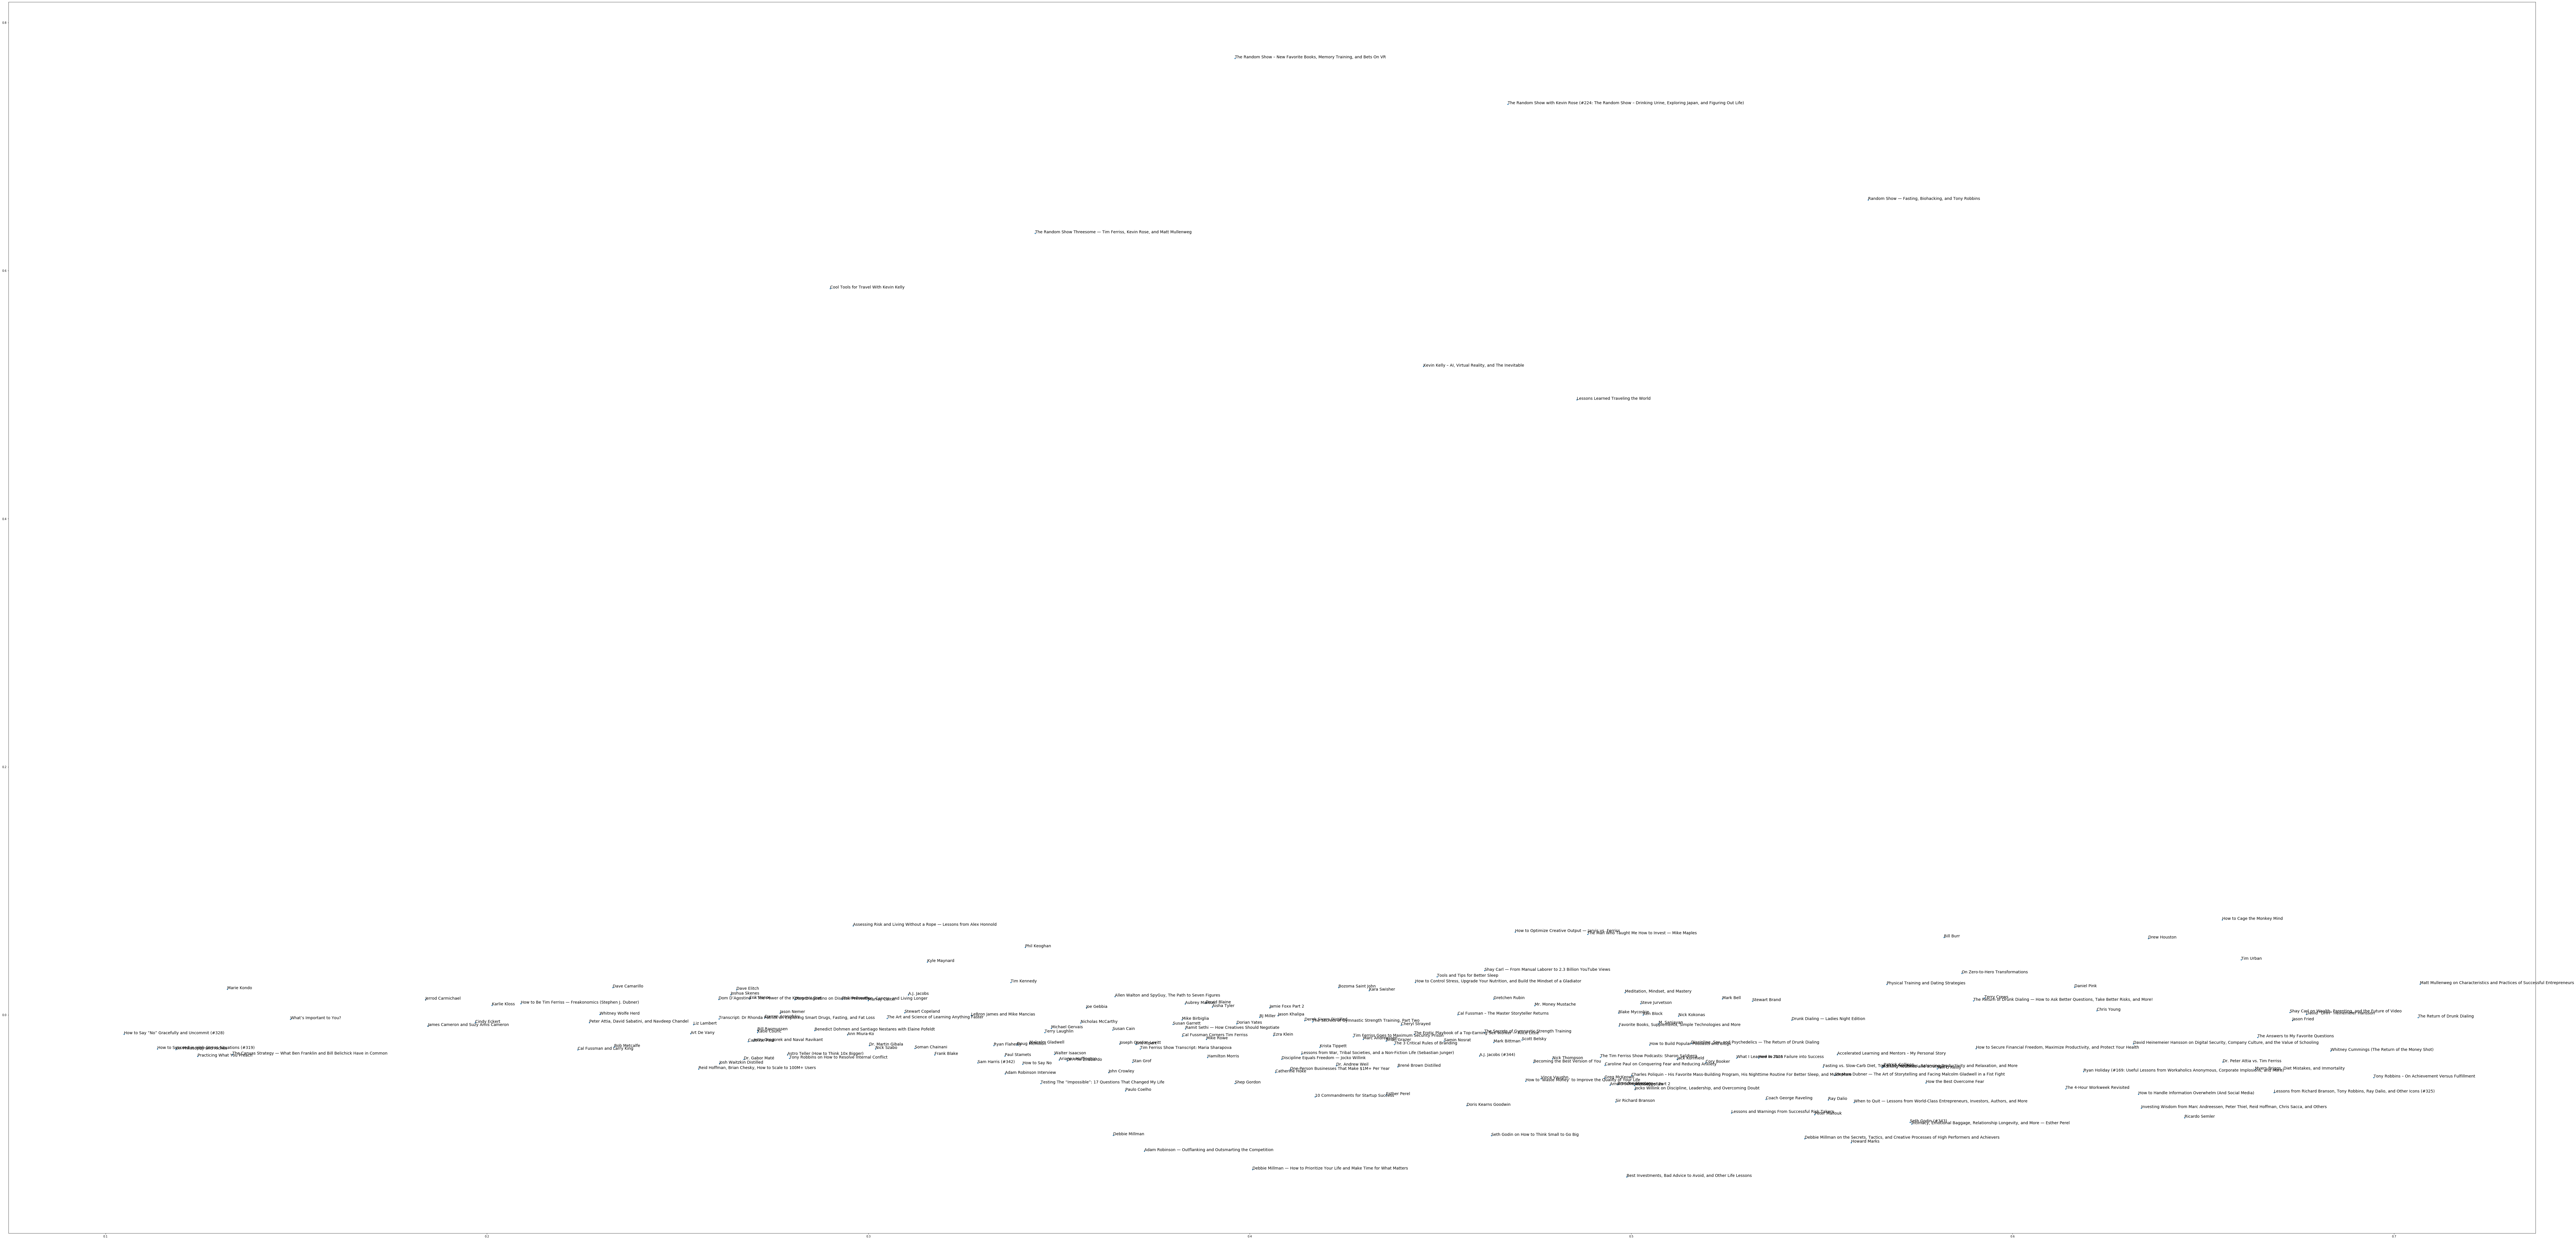

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.003s...
[t-SNE] Computed neighbors for 208 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 0.255282
[t-SNE] KL divergence after 250 iterations with early exaggeration: 173.937485
[t-SNE] KL divergence after 300 iterations: 2.124499


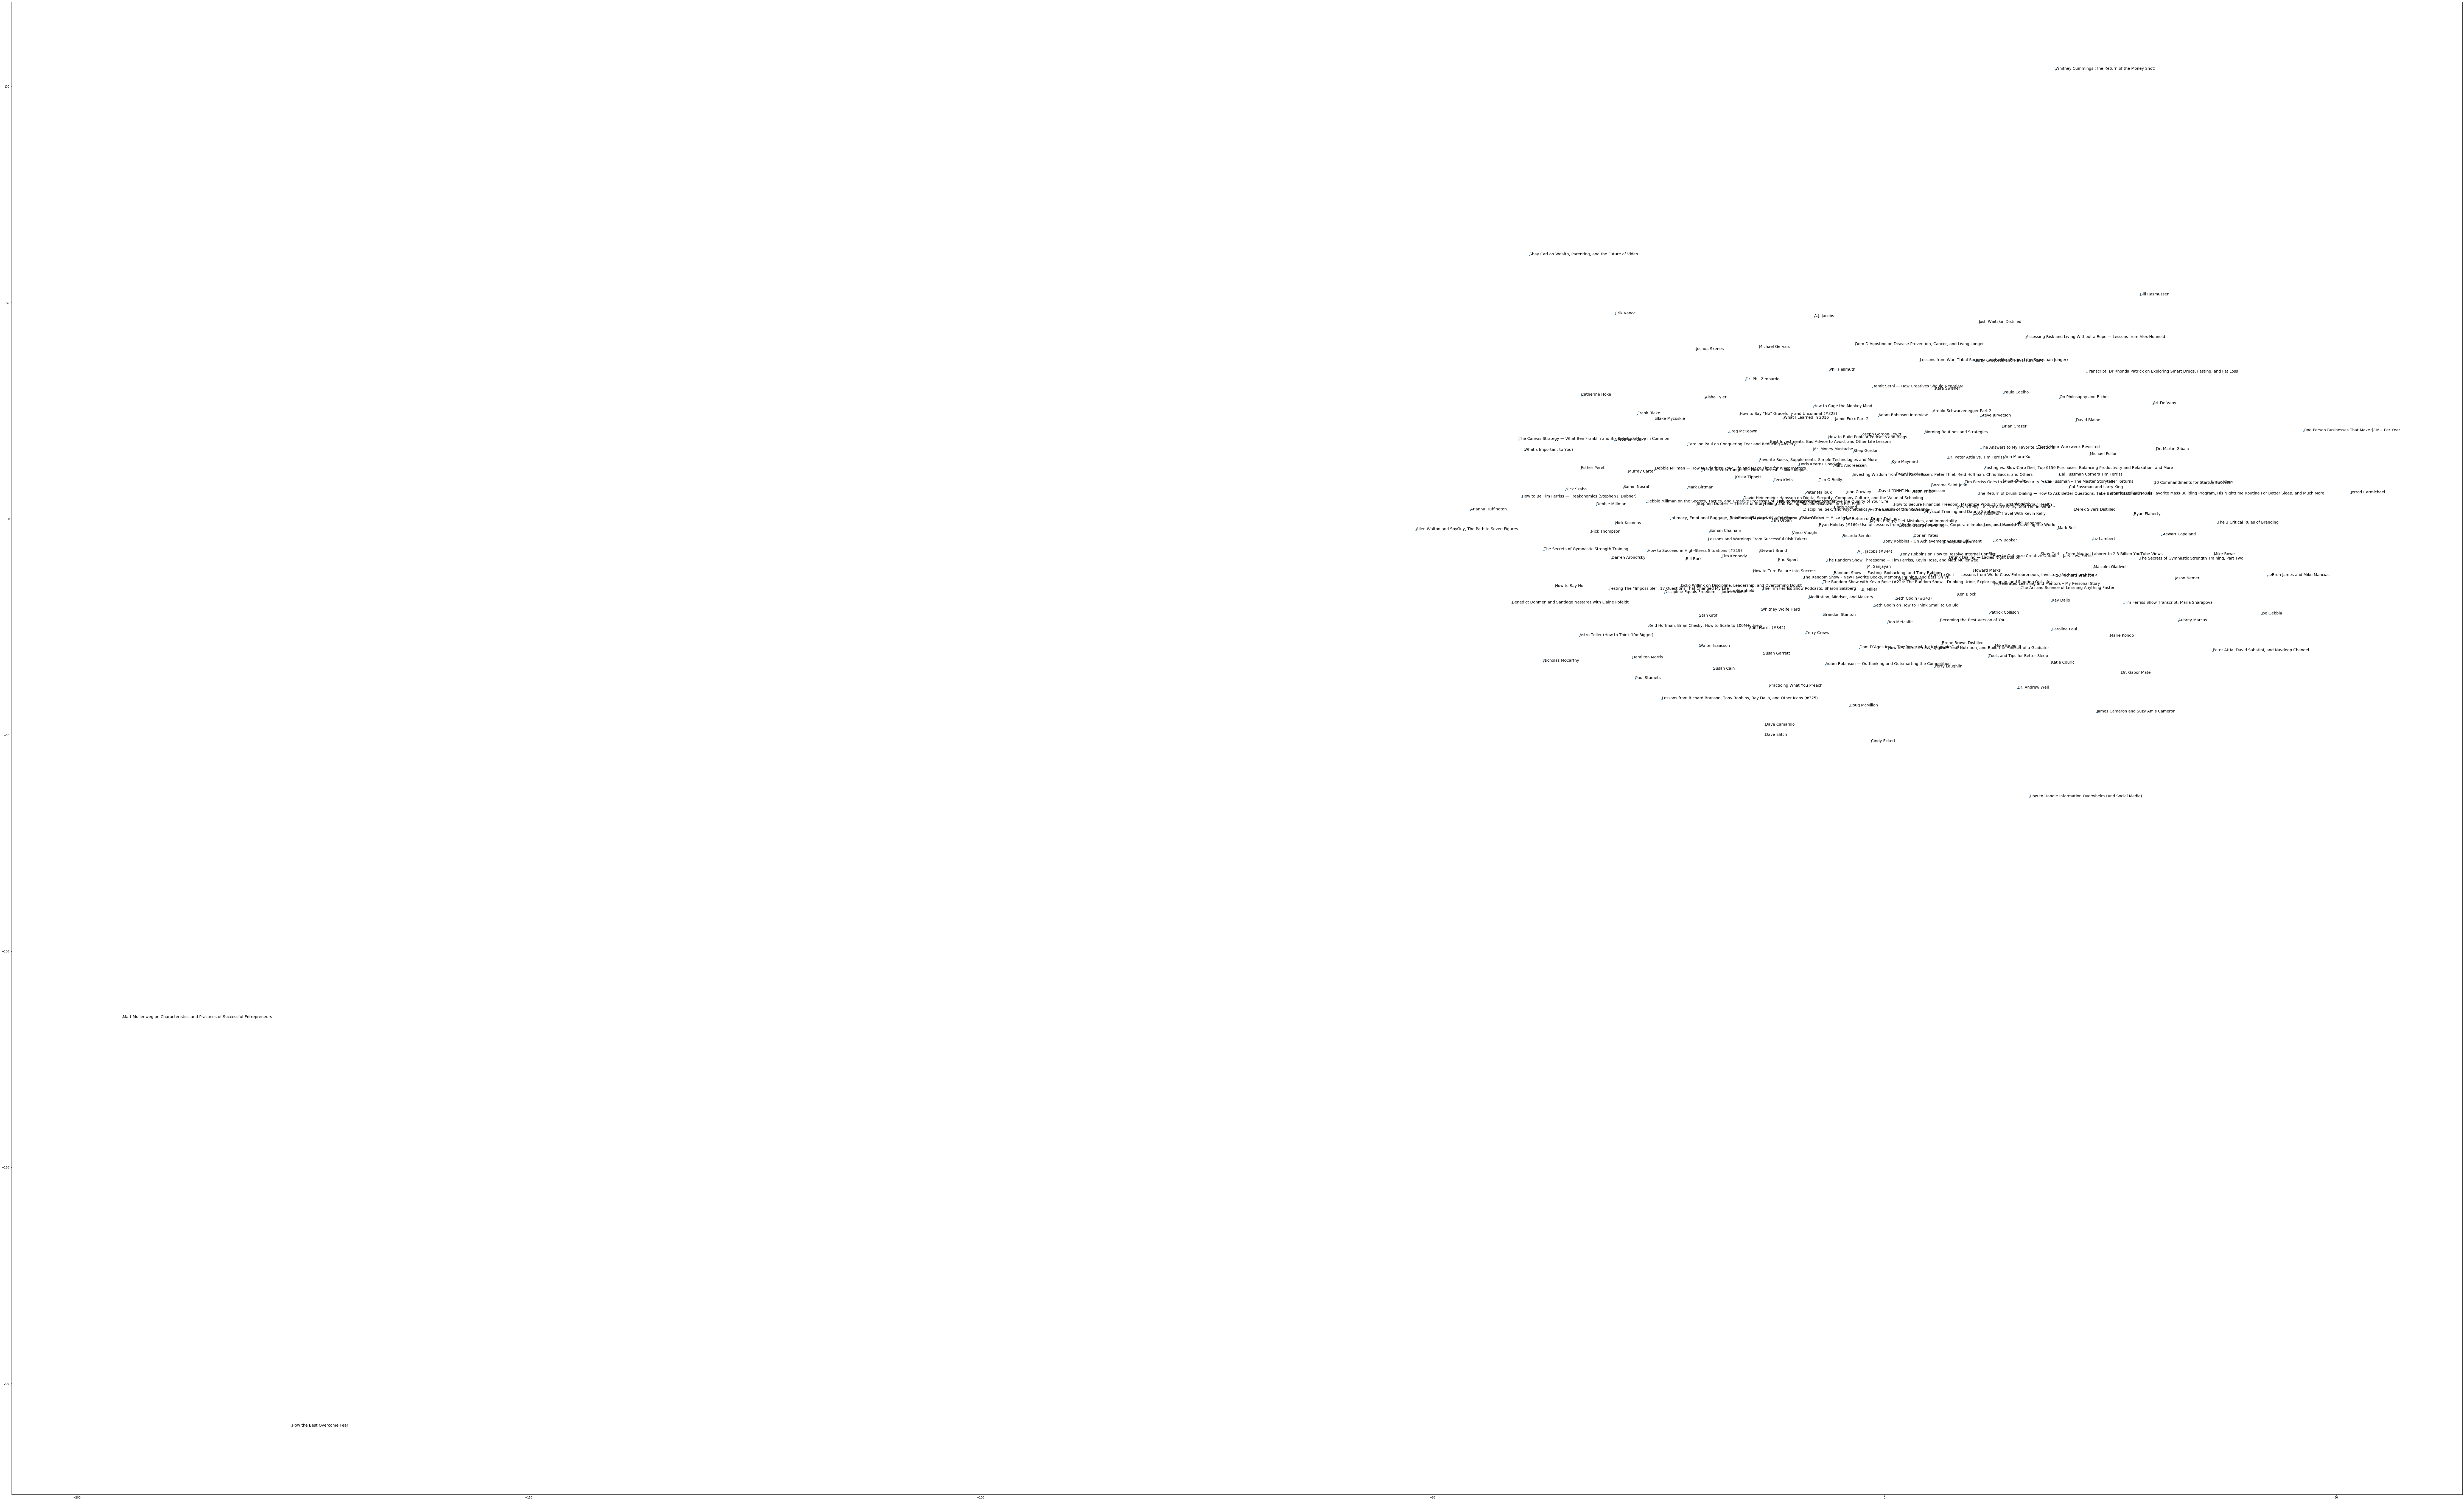

In [13]:

# Plot TFIDF

fig = plt.figure(figsize=(160, 80))
plot_LSA(X_train_tfidf, y_train)
plt.show()

fig = plt.figure(figsize=(160, 100))
plot_TSNE(X_train_tfidf.toarray(), y_train)
plt.show()


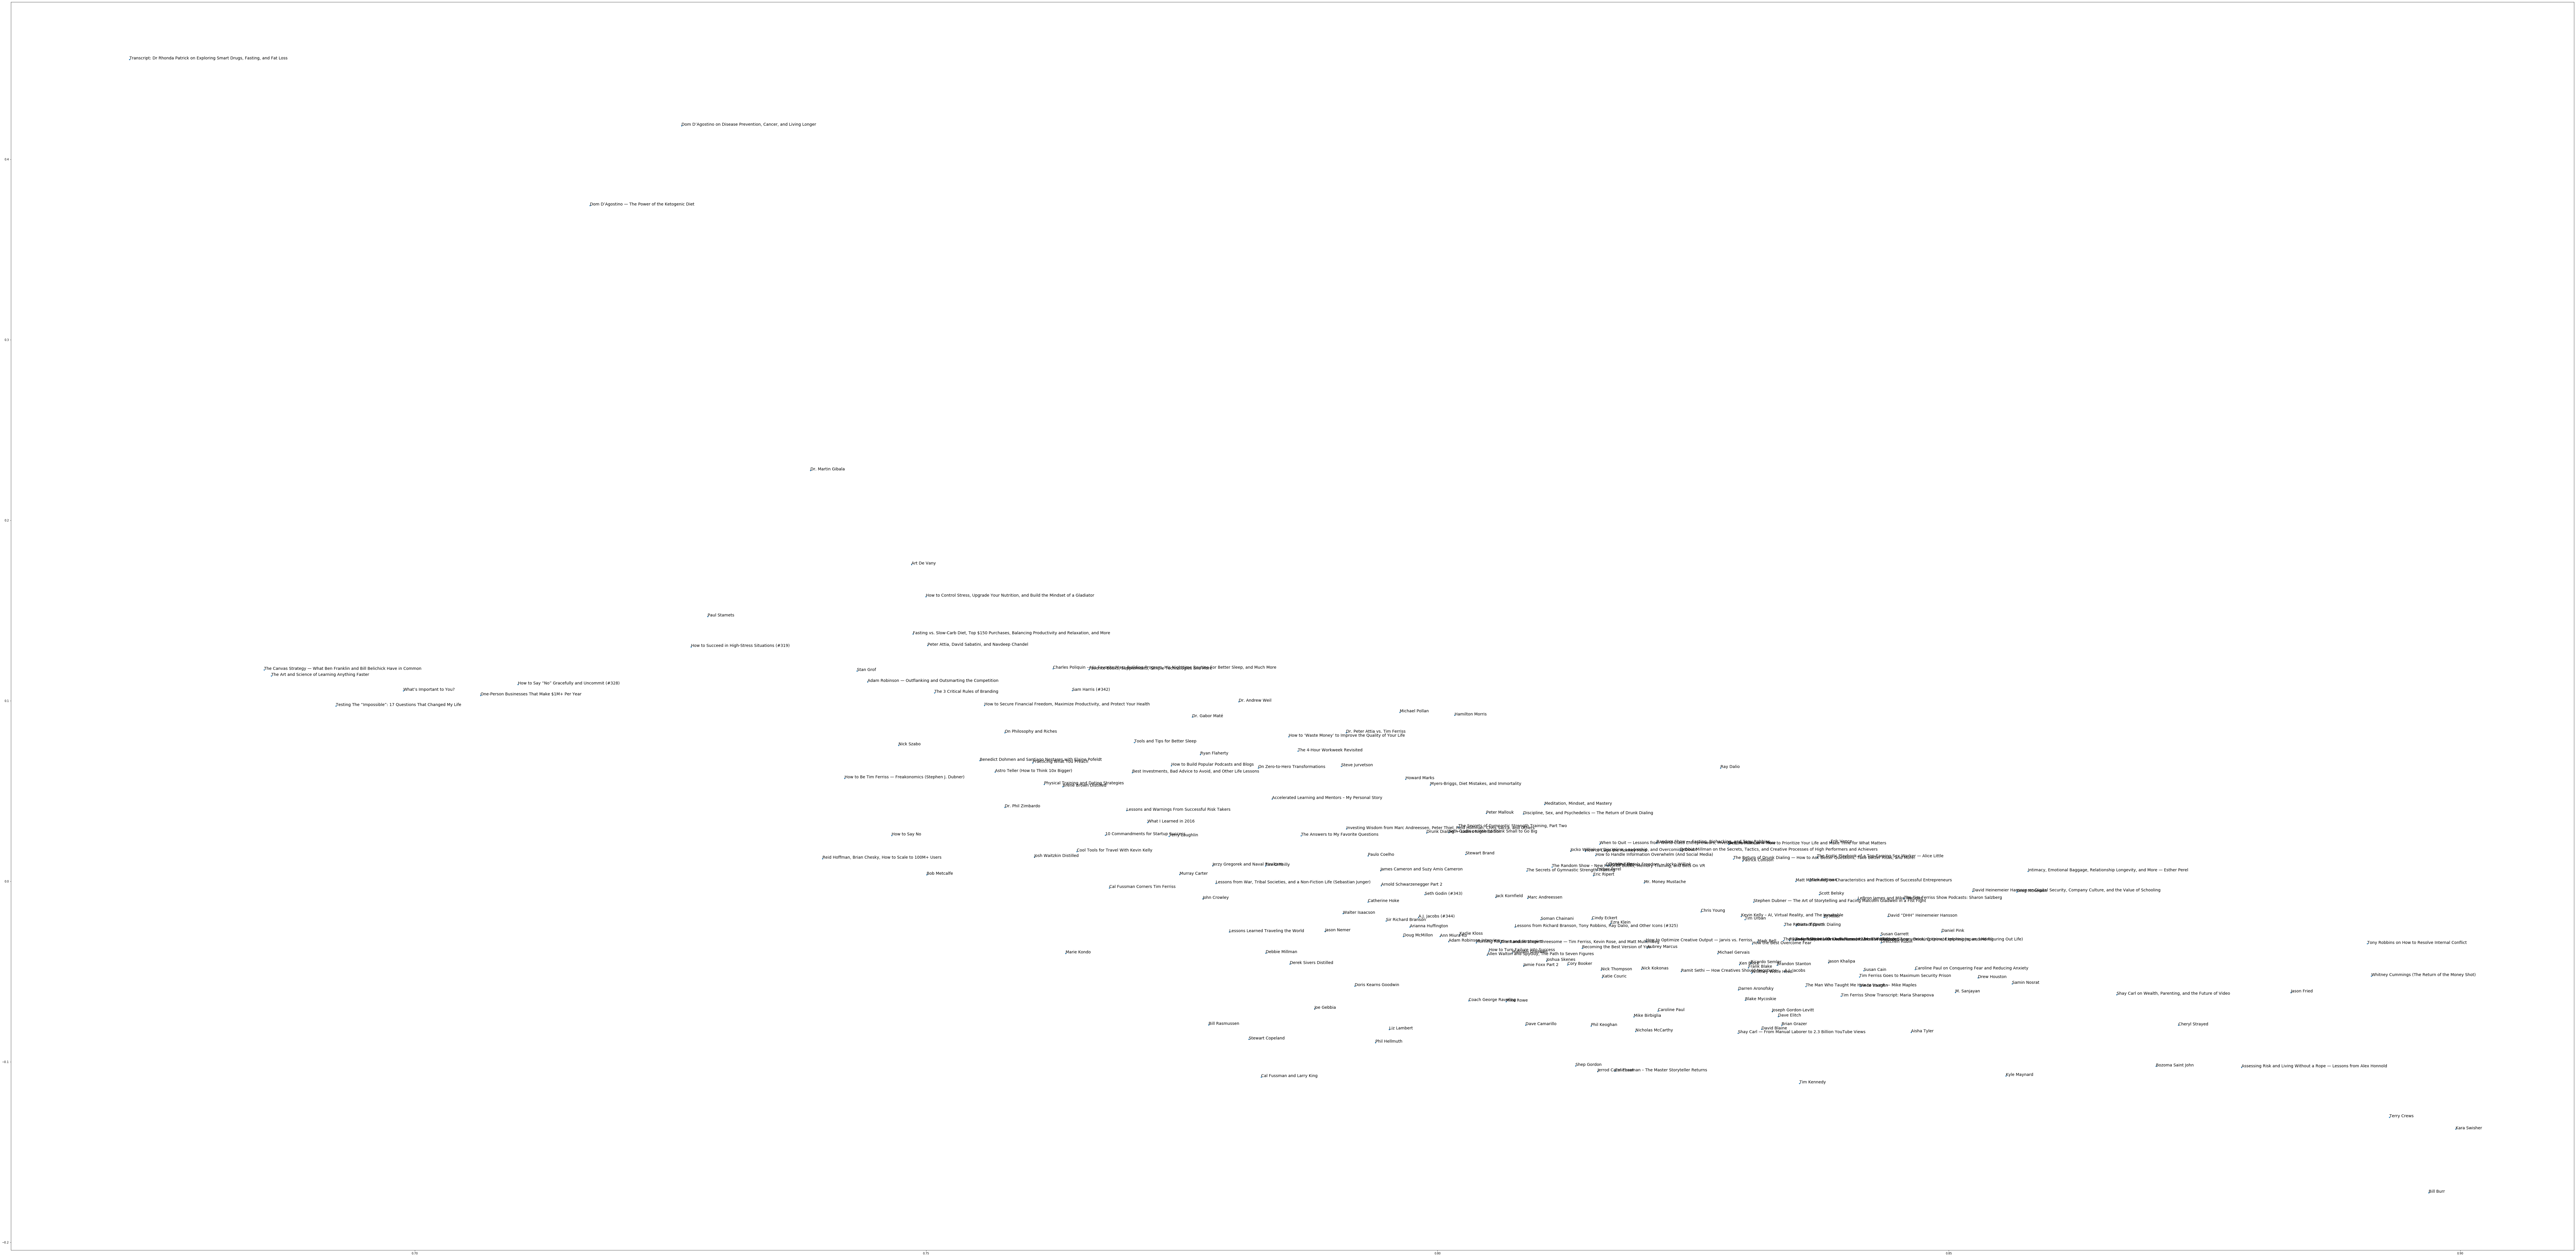

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.001s...
[t-SNE] Computed neighbors for 208 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 0.070045
[t-SNE] KL divergence after 250 iterations with early exaggeration: 125.940071
[t-SNE] KL divergence after 300 iterations: 1.138741


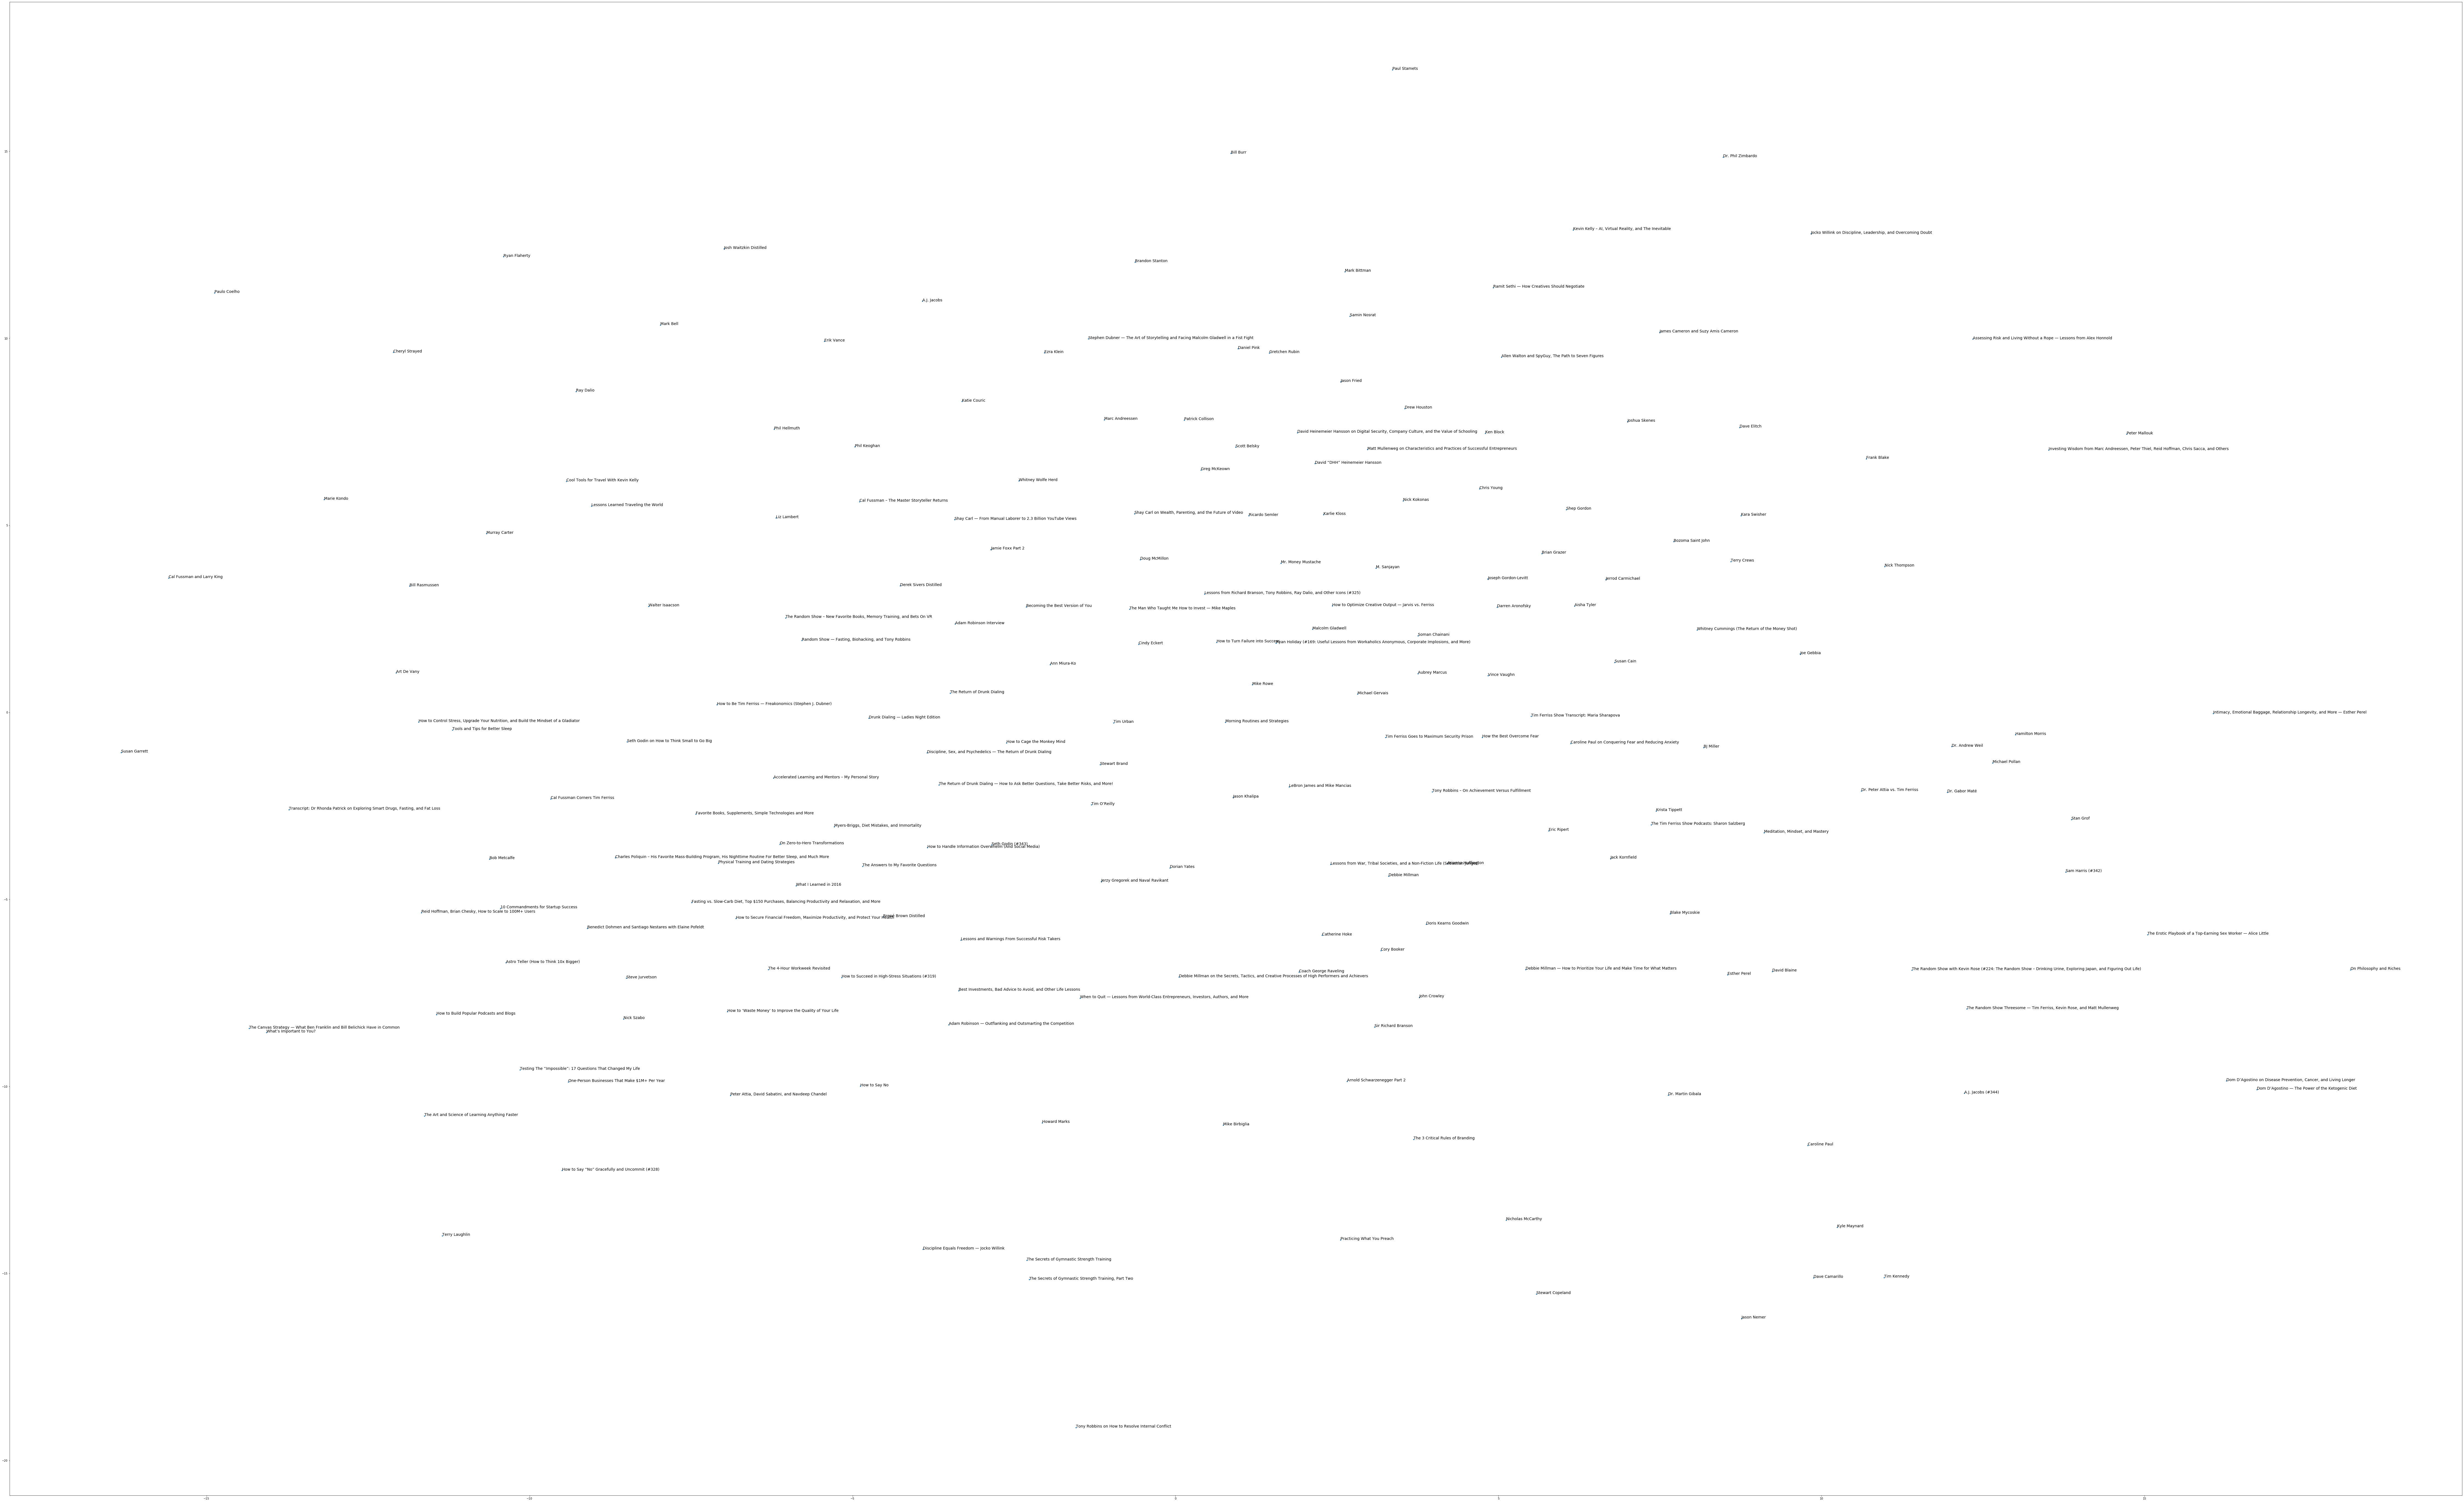

In [14]:
word2vec_path = "./pretrainedModels/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

embeddings = get_word2vec_embeddings(word2vec, clean_questions)

fig = plt.figure(figsize=(160, 80))         
plot_LSA(embeddings, y_train)
plt.show()

fig = plt.figure(figsize=(160, 100))
plot_TSNE(embeddings, y_train)
plt.show()


In [15]:
# Modeling

## get the categories (topics of the podcast)
# 0 = random 
# 1 = health
# 2 = wealth
# 3 = wise

categories = pd.read_csv("./cleaned/clean_categories.csv")
categories = categories.drop(columns=['id', 'title'])

df = pd.DataFrame()
df = pd.concat([clean_questions, categories], axis=1)
df = df.dropna()

X = df['text']

y = df['category']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)


In [16]:
# Use TFIDF
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

rfc = ensemble.RandomForestClassifier(criterion='entropy', n_jobs=4)
# Fit the best algorithm to the data. 
rfc.fit(X_train_tfidf, y_train)
print('train: ', rfc.score(X_train_tfidf, y_train))
print('test: ', rfc.score(X_test_tfidf, y_test))

y_pred = rfc.predict(X_test_tfidf)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('RFC:\n', classification_report(y_test, y_pred, target_names=['0', '1', '2', '3']))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train:  1.0
test:  0.5294117647058824
Confusion Matrix
 Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0          5    0    0    1    6
1.0          0    1    0    0    1
2.0          3    0    1    1    5
3.0          3    0    0    2    5
All         11    1    1    4   17
RFC:
               precision    recall  f1-score   support

           0       0.45      0.83      0.59         6
           1       1.00      1.00      1.00         1
           2       1.00      0.20      0.33         5
           3       0.50      0.40      0.44         5

    accuracy                           0.53        17
   macro avg       0.74      0.61      0.59        17
weighted avg       0.66      0.53      0.50        17



In [21]:
# Use word2vec embeddings
df = pd.DataFrame(embeddings)
df = pd.concat([df, categories], axis=1)
df = df.dropna()

X = df.drop(columns=['category', 'episode'])

y = df['category']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)


In [22]:
rfc = ensemble.RandomForestClassifier(criterion='entropy', n_jobs=4)
# Fit the best algorithm to the data. 
rfc.fit(X_train, y_train)
print('train: ', rfc.score(X_train, y_train))
print('test: ', rfc.score(X_test, y_test))

y_pred = rfc.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('RFC:\n', classification_report(y_test, y_pred, target_names=['0', '1', '2', '3']))

score = cross_val_score(rfc, X, y, cv=5, n_jobs=-1, verbose=1)
print("RFC: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train:  1.0
test:  0.5882352941176471
Confusion Matrix
 Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0          5    0    0    1    6
1.0          0    1    0    0    1
2.0          3    0    1    1    5
3.0          2    0    0    3    5
All         10    1    1    5   17
RFC:
               precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       1.00      1.00      1.00         1
           2       1.00      0.20      0.33         5
           3       0.60      0.60      0.60         5

    accuracy                           0.59        17
   macro avg       0.78      0.66      0.64        17
weighted avg       0.71      0.59      0.55        17



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RFC: Input X --> Recall: 0.454 (+/- 0.170)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [28]:
# Random Forest: 
rfc = ensemble.RandomForestClassifier(criterion='entropy', n_jobs=4)

# Choose some parameter combinations to try
parameters = {'n_estimators': [16, 32, 64], 
              #'max_features': ['log2', 'sqrt','auto'], 
              #'criterion': ['entropy', 'gini'],
              'max_depth': [5, 10, 13], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 2, 5]
             }

# Run the grid search
grid_obj = GridSearchCV(rfc, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    7.6s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [38]:
rfc = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Fit the best algorithm to the data. 
rfc.fit(X_train, y_train)
print('train: ', rfc.score(X_train, y_train))
print('test: ', rfc.score(X_test, y_test))

y_pred = rfc.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('RFC:\n', classification_report(y_test, y_pred, target_names=['0', '1', '2', '3']))
score = cross_val_score(rfc, X, y, cv=5, n_jobs=-1, verbose=1)
print("RFC: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))



train:  1.0
test:  0.7058823529411765
Confusion Matrix
 Predicted  0.0  1.0  2.0  3.0  All
True                              
0.0          5    0    0    1    6
1.0          0    1    0    0    1
2.0          0    0    4    1    5
3.0          3    0    0    2    5
All          8    1    4    4   17
RFC:
               precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       1.00      1.00      1.00         1
           2       1.00      0.80      0.89         5
           3       0.50      0.40      0.44         5

    accuracy                           0.71        17
   macro avg       0.78      0.76      0.76        17
weighted avg       0.72      0.71      0.70        17



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RFC: Input X --> Recall: 0.639 (+/- 0.127)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


 ### Findings:
 Best model is the last rfc with word2vec embeddings:
 Increased RFC: Input X --> Recall: 0.454 (+/- 0.170) to 0.639 (+/- 0.127)